In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras_tuner as kt
import keras

## Konfiguracja

In [2]:
train_data_dir="./Trees"
validation_data_dir="./Trees"
batch_size=16
img_height, img_width = 60,80

## Generowanie zdjęć

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, # view images from various angles
    zoom_range=0.2,
    horizontal_flip=True, # randomly flip img horizontally
    vertical_flip=True, # randomly flip img vertically
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    validation_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 759 images belonging to 3 classes.
Found 187 images belonging to 3 classes.


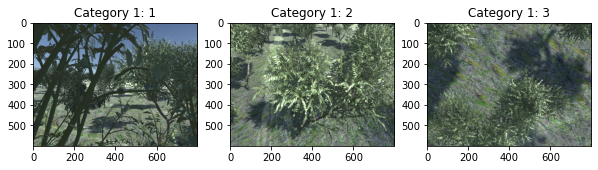

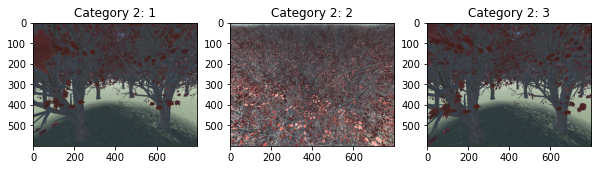

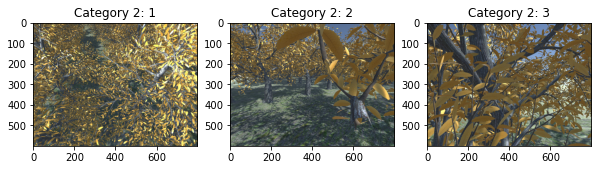

In [4]:
def plot_image(fname, label, col):
    img = mpimg.imread(train_data_dir + '/' + fname)
    plt.subplot(1,3,col)
    plt.title(label)
    plt.imshow(img)
    
plt.figure(figsize=(10,5))
cat1_files = ['AS12_7/18.png','AS12_7/103.png','AS12_7/225.png']
for idx, f in enumerate(cat1_files):
    plot_image(f, f'Category 1: {idx+1}', idx + 1)
plt.show()

plt.figure(figsize=(10,5))
cat2_files = ['EA01a/15.png','EA01a/5.png','EA01a/12.png']
for idx, f in enumerate(cat2_files):
    plot_image(f, f'Category 2: {idx+1}', idx + 1)
plt.show()


plt.figure(figsize=(10,5))
cat3_files = ['EU43_6/135.png','EU43_6/195.png','EU43_6/16.png']
for idx, f in enumerate(cat3_files):
    plot_image(f, f'Category 2: {idx+1}', idx + 1)
plt.show()

## CNN

In [5]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))

model.add(Dense(3, activation='softmax'))

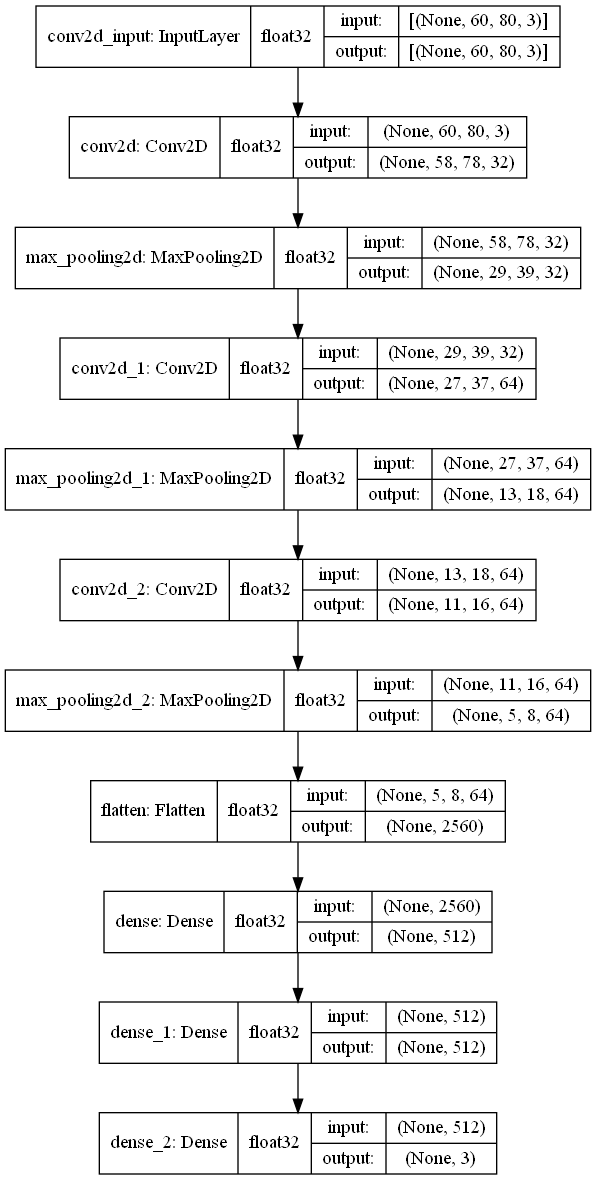

In [6]:
plot_model(model, to_file='model1_plot.png', show_shapes=True,show_dtype=True, show_layer_names=True, expand_nested=True,)

In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0

In [8]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [9]:
history = model.fit(train_generator, epochs=16,  verbose=1,
                   validation_data = validation_generator, validation_steps = 4)

Epoch 1/16
48/48 [==============================] - 21s 419ms/step - loss: 0.8317 - accuracy: 0.6440 - val_loss: 0.7841 - val_accuracy: 0.8125
Epoch 2/16
48/48 [==============================] - 18s 376ms/step - loss: 0.6134 - accuracy: 0.7810 - val_loss: 0.3542 - val_accuracy: 0.8438
Epoch 3/16
48/48 [==============================] - 18s 377ms/step - loss: 0.4492 - accuracy: 0.8211 - val_loss: 0.2147 - val_accuracy: 0.9531
Epoch 4/16
48/48 [==============================] - 18s 367ms/step - loss: 0.2990 - accuracy: 0.9016 - val_loss: 0.4539 - val_accuracy: 0.8125
Epoch 5/16
48/48 [==============================] - 18s 379ms/step - loss: 0.2767 - accuracy: 0.8925 - val_loss: 0.0954 - val_accuracy: 0.9531
Epoch 6/16
48/48 [==============================] - 17s 364ms/step - loss: 0.2011 - accuracy: 0.9363 - val_loss: 0.1089 - val_accuracy: 0.9688
Epoch 7/16
48/48 [==============================] - 17s 362ms/step - loss: 0.2036 - accuracy: 0.9311 - val_loss: 0.0708 - val_accuracy: 1.0000

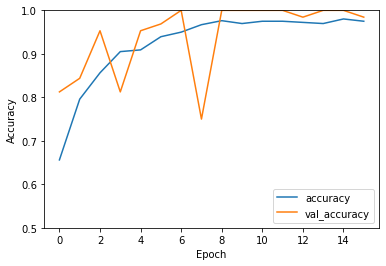

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## CNN + hyperparameter tuning

In [15]:
def build_model(hp):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = inputs
    for i in range(hp.Int("cnn_layers", 1, 3)):
        x = Conv2D(
            hp.Int(f"filters_{i}", 32, 128, step=32),
            kernel_size=(3, 3),
            activation="relu",
        )(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    # A hyperparamter for whether to use dropout layer.
    if hp.Boolean("dropout"):
        x = Dropout(0.5)(x)

    outputs = Dense(units=3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model.
    model.compile(
        optimizer=RMSprop(learning_rate=0.0001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'],
    )
    return model


In [17]:
hp = kt.HyperParameters()
model = build_model(hp)

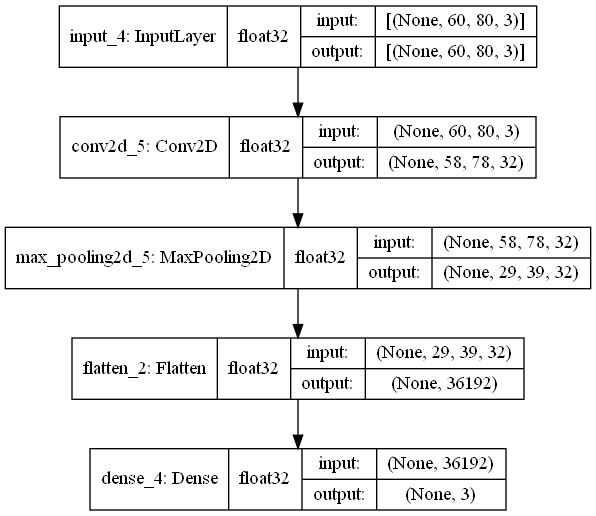

In [18]:
plot_model(model, to_file='model2_plot.png', show_shapes=True,show_dtype=True, show_layer_names=True, expand_nested=True,)

In [19]:
history = model.fit(train_generator, verbose=1, epochs=16,
                   validation_data = validation_generator, validation_steps = 4)

Epoch 1/16
48/48 [==============================] - 17s 342ms/step - loss: 0.7536 - accuracy: 0.6303 - val_loss: 0.5446 - val_accuracy: 0.9375
Epoch 2/16
48/48 [==============================] - 18s 369ms/step - loss: 0.4898 - accuracy: 0.8538 - val_loss: 0.3223 - val_accuracy: 0.9531
Epoch 3/16
48/48 [==============================] - 17s 362ms/step - loss: 0.3330 - accuracy: 0.8921 - val_loss: 0.1827 - val_accuracy: 0.9844
Epoch 4/16
48/48 [==============================] - 18s 380ms/step - loss: 0.2685 - accuracy: 0.9094 - val_loss: 0.2703 - val_accuracy: 0.9844
Epoch 5/16
48/48 [==============================] - 19s 403ms/step - loss: 0.2051 - accuracy: 0.9460 - val_loss: 0.2149 - val_accuracy: 0.9844
Epoch 6/16
48/48 [==============================] - 19s 403ms/step - loss: 0.1838 - accuracy: 0.9561 - val_loss: 0.1424 - val_accuracy: 0.9531
Epoch 7/16
48/48 [==============================] - 19s 394ms/step - loss: 0.1609 - accuracy: 0.9720 - val_loss: 0.1484 - val_accuracy: 0.9688

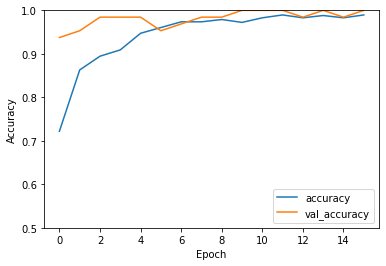

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# MLP

In [21]:
model = Sequential()
model.add(Flatten(input_shape=(img_height, img_width, 3), name="Input_layer"))
model.add(Dense(350, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

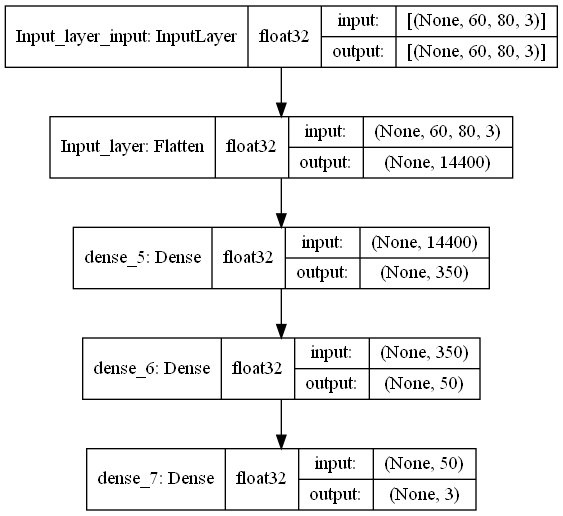

In [22]:
plot_model(model, to_file='model3_plot.png', show_shapes=True,show_dtype=True, show_layer_names=True, expand_nested=True,)

In [23]:
model.compile(
        optimizer=RMSprop(learning_rate=0.0001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'],
    )

In [24]:
history = model.fit(train_generator, verbose=1, epochs=16,
                   validation_data = validation_generator, validation_steps = 4)

Epoch 1/16
48/48 [==============================] - 19s 388ms/step - loss: 1.2904 - accuracy: 0.5216 - val_loss: 0.6917 - val_accuracy: 0.6562
Epoch 2/16
48/48 [==============================] - 19s 404ms/step - loss: 0.6465 - accuracy: 0.7112 - val_loss: 0.7890 - val_accuracy: 0.6719
Epoch 3/16
48/48 [==============================] - 18s 383ms/step - loss: 0.5448 - accuracy: 0.7737 - val_loss: 0.4680 - val_accuracy: 0.8594
Epoch 4/16
48/48 [==============================] - 18s 368ms/step - loss: 0.4313 - accuracy: 0.8452 - val_loss: 0.5577 - val_accuracy: 0.7500
Epoch 5/16
48/48 [==============================] - 24s 501ms/step - loss: 0.4464 - accuracy: 0.8121 - val_loss: 0.2900 - val_accuracy: 0.7969
Epoch 6/16
48/48 [==============================] - 21s 438ms/step - loss: 0.3362 - accuracy: 0.8622 - val_loss: 0.2690 - val_accuracy: 0.7969
Epoch 7/16
48/48 [==============================] - 20s 426ms/step - loss: 0.3143 - accuracy: 0.8954 - val_loss: 0.3525 - val_accuracy: 0.8438

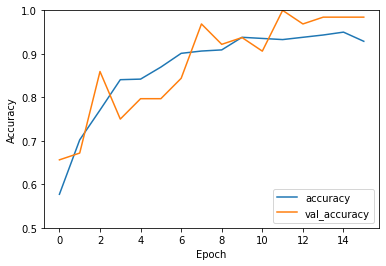

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')